On recommence en mettant la boucle et en ajoutant la baseline : 

##
<center><span style="color: seagreen; font-size: 50px; font-style: bold">Pipeline d'analyse de spectres de spectroscopie Raman avec méthode SERS pour titration du Cuivre</span></center>


<!DOCTYPE html>
<html lang="fr">
<head>
    <meta charset="UTF-8">
    <title>Pipeline d'analyse de spectre de spectroscopie Raman avec méthode SERS pour titration du Cuivre</title>
    <style>
        body {
            font-family: Arial, sans-serif;
        }
        h1 {
            color: skyblue;
            font-size: 24px;
        }
        p, li {
            font-size: 16px;
        }
        .green-text{
            color: DarkSeaGreen;
        }
    </style>
</head>
<body>
    <h1>Analyse spectroscopique</h1>
    <p>Ce code permet d'analyser les données issues de spectroscope Raman. Les données doivent être données dans des fichiers standarisé ".txt". Le code fonctionne comme suit: </p>
    <ol>
        <li><strong class="green-text">Récupération des spectres :</strong> Collecte de tous les spectres issus d'une même expérience.</li>
        <li><strong class="green-text"> Pré-traitement:</strong> Soustraction d'une base-line pour uniformisé les spectres.</li>
        <li><strong class="green-text"> Téléchargement des métadonnés de l'expérience:</strong> Un tableur récapitulant l'intégralité des manipulations lors de l'expérience est chargé pour compléter les données nécessaires à la titration.</li>
        <li><strong class="green-text"> Hauteur de pics:</strong> Lecture de la valeur des pics définis, et calcul de leur rapport pour chaque mesure.</li>
        <li><strong class="green-text"Tracè des courbes de titrations :</strong> Application de méthodes statistiques aux trajectoires conservées. Les données peuvent être séparées en deux populations pour un traitement spécifique si nécessaire.</li>
    </ol>
</body>
</html>


<span style="color: skyblue; font-size: 20px; font-style: bold">Chargement des librairies.</span>

In [200]:
import os
import re
import itertools
import numpy as np
import pandas as pd
from pybaselines import Baseline
from plotnine import ggplot, aes, geom_point, geom_line, theme_bw, labs, scale_color_brewer, theme, scale_x_continuous, ylim
import matplotlib.pyplot as plt

<span style="color: skyblue; font-size: 20px; font-style: bold"> Paramètresde l'étude </span>

In [201]:
EXPERIMENT_NAME = "AS003"
WAVELENGTH = "532nm"
EXPERIMENT_FOLDER = EXPERIMENT_NAME + "_" +WAVELENGTH
data_dir = os.path.join('/Users/souchaud/Documents/Travail/CitizenSers/Spectroscopie/', EXPERIMENT_FOLDER)

<span style="color: skyblue; font-size: 20px; font-style: bold"> Téléchargement des méta-donnés de l'expérience </span>

In [202]:
# Lecture du fichier Excel de métadonnées :
metadata_path = "/Users/souchaud/Documents/Travail/CitizenSers/Spectroscopie/"
metadata_df = pd.read_excel(metadata_path + EXPERIMENT_NAME + "_metadata.xlsx", skiprows=1)
metadata_df.head()

,Spectrum name,Sample description,nb average,laser.pwr,laser.WL (nm),acq.time (s),pH,Nb eq,V(EGTA) (µL),V(BRB) (µL),n(EGTA) (mol),V(PAN) (µL),C(PAN) (µM),n(PAN),C(Cu) (nM),C(Ag) (mM)
0,AS003_01,Cuvette BRB,1,30,532,3,NaN,0.0,0.0,500.0,0.000000e+00,0.0,2.2,0.000000e+00,0.0,0.0
1,AS003_02,Cuvette 16 - 0eq EGTA,1,30,532,3,NaN,0.0,0.0,500.0,0.000000e+00,30.0,2.2,6.600000e-11,491.0,1.0
2,AS003_03,Cuvette 17 - 2eq EGTA,1,30,532,3,NaN,2.0,446.0,54.0,9.812000e-10,30.0,2.2,6.600000e-11,491.0,1.0
3,AS003_04,Cuvette BRB,1,30,532,3,NaN,0.0,0.0,500.0,0.000000e+00,0.0,2.2,0.000000e+00,0.0,0.0
4,AS003_05,Cuvette 1 - Oeq EGTA,1,30,532,3,7.82,0.0,0.0,500.0,0.000000e+00,30.0,2.2,6.600000e-11,491.0,1.0


<span style="color: skyblue; font-size: 20px; font-style: bold"> Liste des fichiers de la manip </span>

In [203]:
spectrocopy_files = [f for f in os.listdir(data_dir)
                    if f.endswith('.txt')]

# trie dans l'ordre croissant en extrayant la partie numérique
spectrocopy_files = sorted(
    spectrocopy_files,
    key=lambda x: int(re.search(r'_(\d+)\.txt$', x).group(1)) 
)

spectrocopy_files

['AS003_01.txt',
 'AS003_02.txt',
 'AS003_03.txt',
 'AS003_04.txt',
 'AS003_05.txt',
 'AS003_06.txt',
 'AS003_07.txt',
 'AS003_08.txt',
 'AS003_09.txt',
 'AS003_10.txt',
 'AS003_11.txt',
 'AS003_12.txt',
 'AS003_13.txt',
 'AS003_14.txt',
 'AS003_15.txt',
 'AS003_16.txt',
 'AS003_17.txt',
 'AS003_18.txt',
 'AS003_19.txt',
 'AS003_20.txt',
 'AS003_21.txt',
 'AS003_22.txt',
 'AS003_219.txt',
 'AS003_220.txt']

In [220]:
file_path = os.path.join(data_dir, spectrocopy_files[1])
header_idx = next(i for i, line in enumerate(lines)
                if line.strip().startswith('Pixel;'))
prout = pd.read_csv(file_path,
                    skiprows=header_idx,
                    sep=";",
                    decimal=",",
                    encoding="utf-8",
                    skipinitialspace=True,
                    na_values=["", " ", "   ", "\t"],
                    keep_default_na=True)
prout.columns

Index(['Pixel', 'Wavelength', 'Wavenumber', 'Raman Shift', 'Dark', 'Reference',
       'Raw data #1', 'Dark Subtracted #1', '%TR #1', 'Absorbance #1',
       'Irradiance (lumen) #1', 'Unnamed: 11'],
      dtype='object')

<span style="color: skyblue; font-size: 20px; font-style: bold"> Démonstration de la soustraction de la baseLine sur spectre </span>

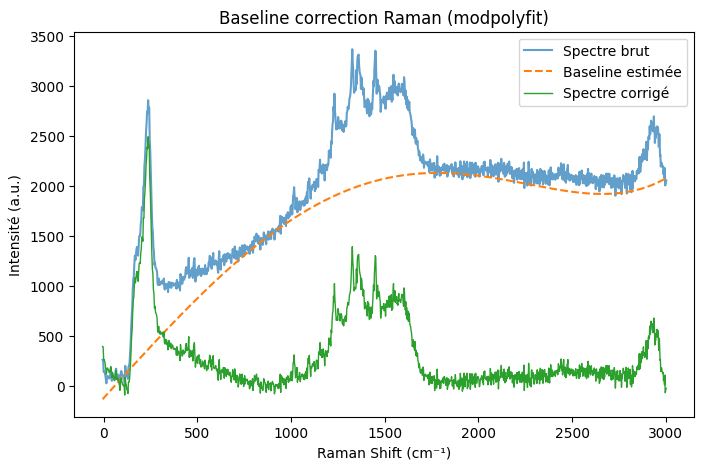

In [204]:
# Exemple : on prend un seul spectre
file_path = os.path.join(data_dir, spectrocopy_files[1])
with open(file_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()

header_idx = next(i for i, line in enumerate(lines)
                if line.strip().startswith('Pixel;'))

# lire le fichier
df = pd.read_csv(file_path,
                    skiprows=header_idx,
                    sep=";",
                    decimal=",",
                    encoding="utf-8",
                    skipinitialspace=True,
                    na_values=["", " ", "   ", "\t"],
                    keep_default_na=True)

# supprimer la dernière colonne si vide
if df.columns[-1].startswith("Unnamed"):
    df = df.iloc[:, :-1]

# convertir en numérique
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = pd.to_numeric(df[col], errors="coerce")

# garder seulement les colonnes utiles
temp = df[["Wavenumber", "Wavelength", "Raman Shift", "Dark Subtracted #1"]].copy()
temp = temp.dropna()

# baseline correction avec modpolyfit
x = temp["Raman Shift"].values
y = temp["Dark Subtracted #1"].values

# Initialiser le modèle
baseline_fitter = Baseline(x)

# Méthode polynomial modpolyfit (comme en R)
baseline, params = baseline_fitter.modpoly(y, poly_order=5)

# Corriger le spectre
y_corrected = y - baseline

# Affichage
plt.figure(figsize=(8, 5))
plt.plot(x, y, label="Spectre brut", alpha=0.7)
plt.plot(x, baseline, label="Baseline estimée", linestyle="--")
plt.plot(x, y_corrected, label="Spectre corrigé", linewidth=1)
plt.xlabel("Raman Shift (cm⁻¹)")
plt.ylabel("Intensité (a.u.)")
plt.legend()
plt.title("Baseline correction Raman (modpolyfit)")
plt.show()

<span style="color: skyblue; font-size: 20px; font-style: bold"> Téléchargement de tous les spectres, application de la baseline, et concaténation de tous les spectres en une seule variable "spectra_df" </span>

In [205]:
all_data = []

for fname in spectrocopy_files:   # ta liste triée
    file_path = os.path.join(data_dir, fname)

    # repérer la ligne de l'en-tête
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    header_idx = next(i for i, line in enumerate(lines)
                      if line.strip().startswith('Pixel;'))

    # lire le fichier
    df = pd.read_csv(file_path,
                     skiprows=header_idx,
                     sep=";",
                     decimal=",",
                     encoding="utf-8",
                     skipinitialspace=True,
                     na_values=["", " ", "   ", "\t"],
                     keep_default_na=True)

    # supprimer la dernière colonne si vide
    if df.columns[-1].startswith("Unnamed"):
        df = df.iloc[:, :-1]

    # convertir en numérique
    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # garder seulement les colonnes utiles
    temp = df[["Wavenumber", "Wavelength", "Raman Shift", "Dark Subtracted #1"]].copy()
    temp = temp.dropna()

    # baseline correction avec modpolyfit
    x = temp["Raman Shift"].values
    y = temp["Dark Subtracted #1"].values
    baseline_fitter = Baseline(x)
    baseline, _ = baseline_fitter.modpoly(y, poly_order=5)

    # ajouter la colonne corrigée
    temp["Intensity_corrected"] = y - baseline
    temp = temp.dropna(subset=["Intensity_corrected"])

    # ajouter une colonne "fichier"
    temp["file"] = fname

    # stocker dans la liste
    all_data.append(temp)

# fusionner tous les fichiers
spectra_df = pd.concat(all_data, ignore_index=True)

spectra_df.head()
# print(spectra_df["file"].unique())

,Wavenumber,Wavelength,Raman Shift,Dark Subtracted #1,Intensity_corrected,file
0,18799.81,531.92,-4.95,328.6667,519.973926,AS003_01.txt
1,18796.91,532.00,-2.05,331.0000,516.631852,AS003_01.txt
2,18794.01,532.08,0.86,156.3333,336.332828,AS003_01.txt
3,18791.11,532.17,3.76,102.3333,276.781821,AS003_01.txt
4,18788.21,532.25,6.65,100.6667,269.644449,AS003_01.txt


<span style="color: skyblue; font-size: 20px; font-style: bold"> Fusion entre datas et metadatas  </span>

In [206]:
#  Création d'une clé de jointure dans spectra_df 
# (on enlève ".txt" pour matcher le nom type"AS00X_Y" dans l'Excel
spectra_df["Spectrum name"] = spectra_df["file"].str.replace(".txt", "", regex=False)

# Fusion des deux tables : 
combined_df = pd.merge(
    spectra_df,
    metadata_df,
    on="Spectrum name",
    how="left"   # garde toutes les lignes de spectra_df
)
# Supprimer les lignes avec "Cuvette BRB"
combined_df = combined_df[combined_df["Sample description"] != "Cuvette BRB"].copy()
# Print du résultat
combined_df.head(10)

# Sauvegarde
# combined_df.to_excel("Spectres_fusionnés.xlsx", index=False)

,Wavenumber,Wavelength,Raman Shift,Dark Subtracted #1,Intensity_corrected,file,Spectrum name,Sample description,nb average,laser.pwr,...,pH,Nb eq,V(EGTA) (µL),V(BRB) (µL),n(EGTA) (mol),V(PAN) (µL),C(PAN) (µM),n(PAN),C(Cu) (nM),C(Ag) (mM)
1295,18799.81,531.92,-4.95,260.3333,394.103951,AS003_02.txt,AS003_02,Cuvette 16 - 0eq EGTA,1,30,...,NaN,0.0,0.0,500.0,0.0,30.0,2.2,6.600000e-11,491.0,1.0
1296,18796.91,532.00,-2.05,263.6667,391.427961,AS003_02.txt,AS003_02,Cuvette 16 - 0eq EGTA,1,30,...,NaN,0.0,0.0,500.0,0.0,30.0,2.2,6.600000e-11,491.0,1.0
1297,18794.01,532.08,0.86,140.0000,261.731195,AS003_02.txt,AS003_02,Cuvette 16 - 0eq EGTA,1,30,...,NaN,0.0,0.0,500.0,0.0,30.0,2.2,6.600000e-11,491.0,1.0
1298,18791.11,532.17,3.76,146.3333,262.055240,AS003_02.txt,AS003_02,Cuvette 16 - 0eq EGTA,1,30,...,NaN,0.0,0.0,500.0,0.0,30.0,2.2,6.600000e-11,491.0,1.0
1299,18788.21,532.25,6.65,135.0000,244.733539,AS003_02.txt,AS003_02,Cuvette 16 - 0eq EGTA,1,30,...,NaN,0.0,0.0,500.0,0.0,30.0,2.2,6.600000e-11,491.0,1.0
1300,18785.31,532.33,9.55,106.0000,209.724591,AS003_02.txt,AS003_02,Cuvette 16 - 0eq EGTA,1,30,...,NaN,0.0,0.0,500.0,0.0,30.0,2.2,6.600000e-11,491.0,1.0
1301,18782.42,532.41,12.45,62.0000,159.715860,AS003_02.txt,AS003_02,Cuvette 16 - 0eq EGTA,1,30,...,NaN,0.0,0.0,500.0,0.0,30.0,2.2,6.600000e-11,491.0,1.0
1302,18779.52,532.49,15.34,25.6667,117.394809,AS003_02.txt,AS003_02,Cuvette 16 - 0eq EGTA,1,30,...,NaN,0.0,0.0,500.0,0.0,30.0,2.2,6.600000e-11,491.0,1.0
1303,18776.63,532.58,18.24,78.3333,164.053242,AS003_02.txt,AS003_02,Cuvette 16 - 0eq EGTA,1,30,...,NaN,0.0,0.0,500.0,0.0,30.0,2.2,6.600000e-11,491.0,1.0
1304,18773.73,532.66,21.13,99.3333,179.066137,AS003_02.txt,AS003_02,Cuvette 16 - 0eq EGTA,1,30,...,NaN,0.0,0.0,500.0,0.0,30.0,2.2,6.600000e-11,491.0,1.0


In [207]:
combined_df['Sample description'].unique()

array(['Cuvette 16 - 0eq EGTA', 'Cuvette 17 - 2eq EGTA',
       'Cuvette 1 - Oeq EGTA', 'Cuvette 2', 'Cuvette 3', 'Cuvette 4',
       'Cuvette 5', 'Cuvette 6', 'Cuvette 7', 'Cuvette 8', 'Cuvette 9',
       'Cuvette 10', 'Cuvette 11', 'Cuvette 12', 'Cuvette 13',
       'Cuvette 14', 'Cuvette 15', 'Cuvette 18 - 0eq Cu', 'Cuvette 19',
       'Cuvette 20'], dtype=object)

<span style="color: skyblue; font-size: 20px; font-style: bold"> Spectre </span>

/Users/souchaud/Documents/Travail/CitizenSers/Spectroscopie/traitement_données/spectroscopie_raman/.spectroscopie_raman/lib/python3.13/site-packages/mizani/palettes.py:557: UserWarning:

Warning message:Brewer palette Paired has a maximum of 12 colors Returning the palette you asked for with that many colors

/Users/souchaud/Documents/Travail/CitizenSers/Spectroscopie/traitement_données/spectroscopie_raman/.spectroscopie_raman/lib/python3.13/site-packages/mizani/palettes.py:557: UserWarning:

Warning message:Brewer palette Paired has a maximum of 12 colors Returning the palette you asked for with that many colors



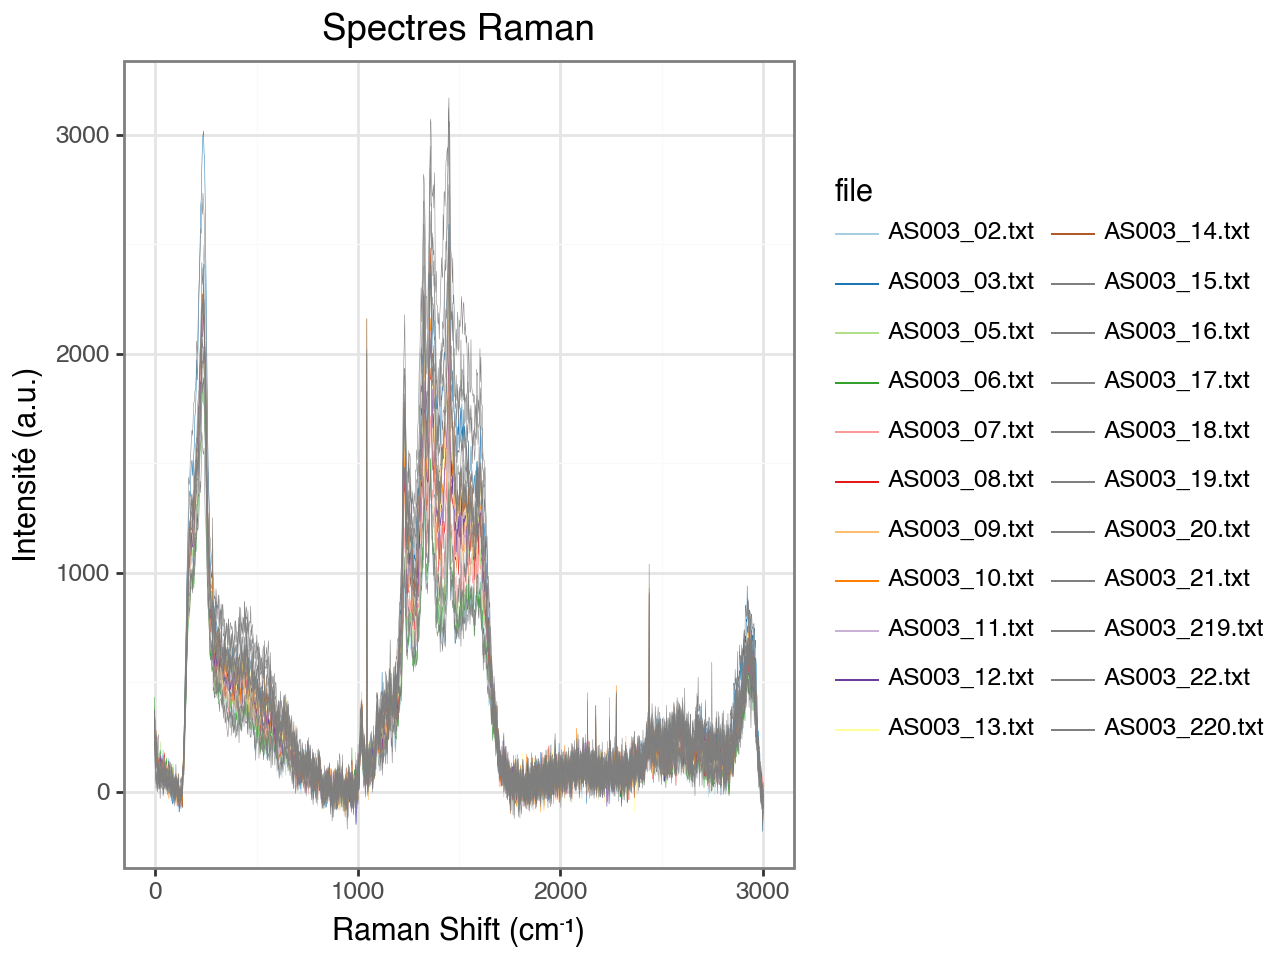

In [208]:
p = (
    ggplot(combined_df, aes(x="Raman Shift", y="Intensity_corrected", color="file"))
    + geom_line(size=0.1)
    + theme_bw()
    + labs(
        title="Spectres Raman",
        x="Raman Shift (cm⁻¹)",
        y="Intensité (a.u.)"
    )
    + scale_color_brewer(type='qual', palette='Paired')  # ou 'Dark2', 'Paired', etc.
)

p

<span style="color: skyblue; font-size: 20px; font-style: bold"> Spectre interactifs </span>

In [209]:
import plotly.express as px

fig = px.line(combined_df, 
              x="Raman Shift", 
              y="Intensity_corrected", 
              color="file",
              title="Spectres Raman interactifs")

fig.update_layout(
    xaxis_title="Raman Shift (cm⁻¹)",
    yaxis_title="Intensité (a.u.)",
    width=1900,   # largeur en pixels
    height=1000   # hauteur en pixels
)

fig.show()

<span style="color: skyblue; font-size: 20px; font-style: bold"> Définitions des pics d'étude </span>

In [210]:
# Liste des pics d’intérêt (en cm⁻¹)
peaks = [1231, 1327, 1342, 1358, 1450]

<span style="color: skyblue; font-size: 20px; font-style: bold"> Récupération des valeurs de pics </span>

In [211]:
# Largeur de la fenêtre de recherche autour de chaque pic
tolerance = 2  # ±5 cm⁻¹

results = []

for fname, group in combined_df.groupby("file"):
    spectrum = group.sort_values("Raman Shift")

    record = {"file": fname}

    for target in peaks:
        # on sélectionne la fenêtre autour du Raman Shift cible
        window = spectrum[
            (spectrum["Raman Shift"] >= target - tolerance) &
            (spectrum["Raman Shift"] <= target + tolerance)
        ]

        if not window.empty:
            # on prend le maximum corrigé dans cette zone
            record[f"I_{target}"] = window["Intensity_corrected"].max()
        else:
            record[f"I_{target}"] = np.nan

    results.append(record)

peak_intensities = pd.DataFrame(results)
peak_intensities.head()

,file,I_1231,I_1327,I_1342,I_1358,I_1450
0,AS003_02.txt,1022.560734,1392.702357,980.272956,1309.963452,1303.917675
1,AS003_03.txt,1702.964159,2265.348436,1638.287673,2368.457740,2592.660290
2,AS003_05.txt,1055.406987,1437.680478,1138.250385,1516.887500,1365.287600
3,AS003_06.txt,1013.235417,1302.784716,1038.215909,1522.611828,1414.868932
4,AS003_07.txt,1206.079463,1525.563560,1219.316226,1717.931360,1686.339571


In [212]:
for (target_a, target_b) in itertools.combinations(peaks, 2):
    peak_intensities[f"ratio_I_{target_a}_I_{target_b}"] = (
        peak_intensities[f"I_{target_a}"] / peak_intensities[f"I_{target_b}"]
    )
peak_intensities.head(10)

,file,I_1231,I_1327,I_1342,I_1358,I_1450,ratio_I_1231_I_1327,ratio_I_1231_I_1342,ratio_I_1231_I_1358,ratio_I_1231_I_1450,ratio_I_1327_I_1342,ratio_I_1327_I_1358,ratio_I_1327_I_1450,ratio_I_1342_I_1358,ratio_I_1342_I_1450,ratio_I_1358_I_1450
0,AS003_02.txt,1022.560734,1392.702357,980.272956,1309.963452,1303.917675,0.734228,1.043139,0.780602,0.784222,1.420729,1.063161,1.068091,0.748321,0.751791,1.004637
1,AS003_03.txt,1702.964159,2265.348436,1638.287673,2368.457740,2592.660290,0.751745,1.039478,0.719018,0.656840,1.382754,0.956466,0.873754,0.691711,0.631894,0.913524
2,AS003_05.txt,1055.406987,1437.680478,1138.250385,1516.887500,1365.287600,0.734104,0.927219,0.695771,0.773029,1.263062,0.947783,1.053024,0.750386,0.833707,1.111039
3,AS003_06.txt,1013.235417,1302.784716,1038.215909,1522.611828,1414.868932,0.777746,0.975939,0.665459,0.716134,1.254830,0.855625,0.920781,0.681865,0.733789,1.076150
4,AS003_07.txt,1206.079463,1525.563560,1219.316226,1717.931360,1686.339571,0.790580,0.989144,0.702053,0.715206,1.251163,0.888024,0.904660,0.709758,0.723055,1.018734
5,AS003_08.txt,1435.979862,1714.243120,1363.646629,1913.528598,1960.209185,0.837676,1.053044,0.750436,0.732565,1.257102,0.895854,0.874521,0.712635,0.695664,0.976186
6,AS003_09.txt,1372.209037,1776.999963,1291.307934,1897.247466,1929.946725,0.772205,1.062651,0.723263,0.711009,1.376124,0.936620,0.920751,0.680622,0.669090,0.983057
7,AS003_10.txt,1589.764957,1887.829870,1520.597655,2162.139706,2077.569776,0.842112,1.045487,0.735274,0.765204,1.241505,0.873130,0.908672,0.703284,0.731912,1.040706
8,AS003_11.txt,1481.324283,1960.794631,1329.604687,2106.269987,2110.070781,0.755471,1.114109,0.703293,0.702026,1.474720,0.930932,0.929255,0.631260,0.630123,0.998199
9,AS003_12.txt,1477.195315,1876.553240,1425.188076,2043.313638,2128.768562,0.787185,1.036491,0.722941,0.693920,1.316706,0.918387,0.881521,0.697489,0.669489,0.959857


In [213]:
# Fusion des intensités avec les métadonnées
peak_intensities["Spectrum name"] = peak_intensities["file"].str.replace(".txt", "", regex=False)
merged = peak_intensities.merge(metadata_df, on="Spectrum name", how="left")
merged.head(10)

,file,I_1231,I_1327,I_1342,I_1358,I_1450,ratio_I_1231_I_1327,ratio_I_1231_I_1342,ratio_I_1231_I_1358,ratio_I_1231_I_1450,...,pH,Nb eq,V(EGTA) (µL),V(BRB) (µL),n(EGTA) (mol),V(PAN) (µL),C(PAN) (µM),n(PAN),C(Cu) (nM),C(Ag) (mM)
0,AS003_02.txt,1022.560734,1392.702357,980.272956,1309.963452,1303.917675,0.734228,1.043139,0.780602,0.784222,...,NaN,0.00,0.0,500.0,0.000000e+00,30.0,2.2,6.600000e-11,491.0,1.0
1,AS003_03.txt,1702.964159,2265.348436,1638.287673,2368.457740,2592.660290,0.751745,1.039478,0.719018,0.656840,...,NaN,2.00,446.0,54.0,9.812000e-10,30.0,2.2,6.600000e-11,491.0,1.0
2,AS003_05.txt,1055.406987,1437.680478,1138.250385,1516.887500,1365.287600,0.734104,0.927219,0.695771,0.773029,...,7.82,0.00,0.0,500.0,0.000000e+00,30.0,2.2,6.600000e-11,491.0,1.0
3,AS003_06.txt,1013.235417,1302.784716,1038.215909,1522.611828,1414.868932,0.777746,0.975939,0.665459,0.716134,...,NaN,0.20,45.0,455.0,9.900000e-11,30.0,2.2,6.600000e-11,491.0,1.0
4,AS003_07.txt,1206.079463,1525.563560,1219.316226,1717.931360,1686.339571,0.790580,0.989144,0.702053,0.715206,...,NaN,0.40,89.0,411.0,1.958000e-10,30.0,2.2,6.600000e-11,491.0,1.0
5,AS003_08.txt,1435.979862,1714.243120,1363.646629,1913.528598,1960.209185,0.837676,1.053044,0.750436,0.732565,...,NaN,0.60,134.0,366.0,2.948000e-10,30.0,2.2,6.600000e-11,491.0,1.0
6,AS003_09.txt,1372.209037,1776.999963,1291.307934,1897.247466,1929.946725,0.772205,1.062651,0.723263,0.711009,...,NaN,0.80,179.0,321.0,3.938000e-10,30.0,2.2,6.600000e-11,491.0,1.0
7,AS003_10.txt,1589.764957,1887.829870,1520.597655,2162.139706,2077.569776,0.842112,1.045487,0.735274,0.765204,...,NaN,0.90,201.0,299.0,4.422000e-10,30.0,2.2,6.600000e-11,491.0,1.0
8,AS003_11.txt,1481.324283,1960.794631,1329.604687,2106.269987,2110.070781,0.755471,1.114109,0.703293,0.702026,...,NaN,0.95,212.0,288.0,4.664000e-10,30.0,2.2,6.600000e-11,491.0,1.0
9,AS003_12.txt,1477.195315,1876.553240,1425.188076,2043.313638,2128.768562,0.787185,1.036491,0.722941,0.693920,...,NaN,1.00,223.0,277.0,4.906000e-10,30.0,2.2,6.600000e-11,491.0,1.0


<span style="color: skyblue; font-size: 20px; font-style: bold"> Calcul des ratios entre deux pics </span>

In [214]:
ratio_cols = [c for c in merged.columns if c.startswith("ratio_I_")]

In [215]:
# Restructurer les données en format long
df_ratios = merged.melt(
    id_vars=["n(EGTA) (mol)", "file"],
    value_vars=ratio_cols,
    var_name="Ratio",
    value_name="Value"
)

<span style="color: skyblue; font-size: 20px; font-style: bold"> Tracés des ratios en fonction de l'EGTA ajouté </span>

/Users/souchaud/Documents/Travail/CitizenSers/Spectroscopie/traitement_données/spectroscopie_raman/.spectroscopie_raman/lib/python3.13/site-packages/mizani/palettes.py:557: UserWarning:

Warning message:Brewer palette Dark2 has a maximum of 8 colors Returning the palette you asked for with that many colors

/Users/souchaud/Documents/Travail/CitizenSers/Spectroscopie/traitement_données/spectroscopie_raman/.spectroscopie_raman/lib/python3.13/site-packages/plotnine/layer.py:372: PlotnineWarning:

geom_point : Removed 20 rows containing missing values.

/Users/souchaud/Documents/Travail/CitizenSers/Spectroscopie/traitement_données/spectroscopie_raman/.spectroscopie_raman/lib/python3.13/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning:

geom_path: Removed 2 rows containing missing values.

/Users/souchaud/Documents/Travail/CitizenSers/Spectroscopie/traitement_données/spectroscopie_raman/.spectroscopie_raman/lib/python3.13/site-packages/mizani/palettes.py:557: UserWarning:


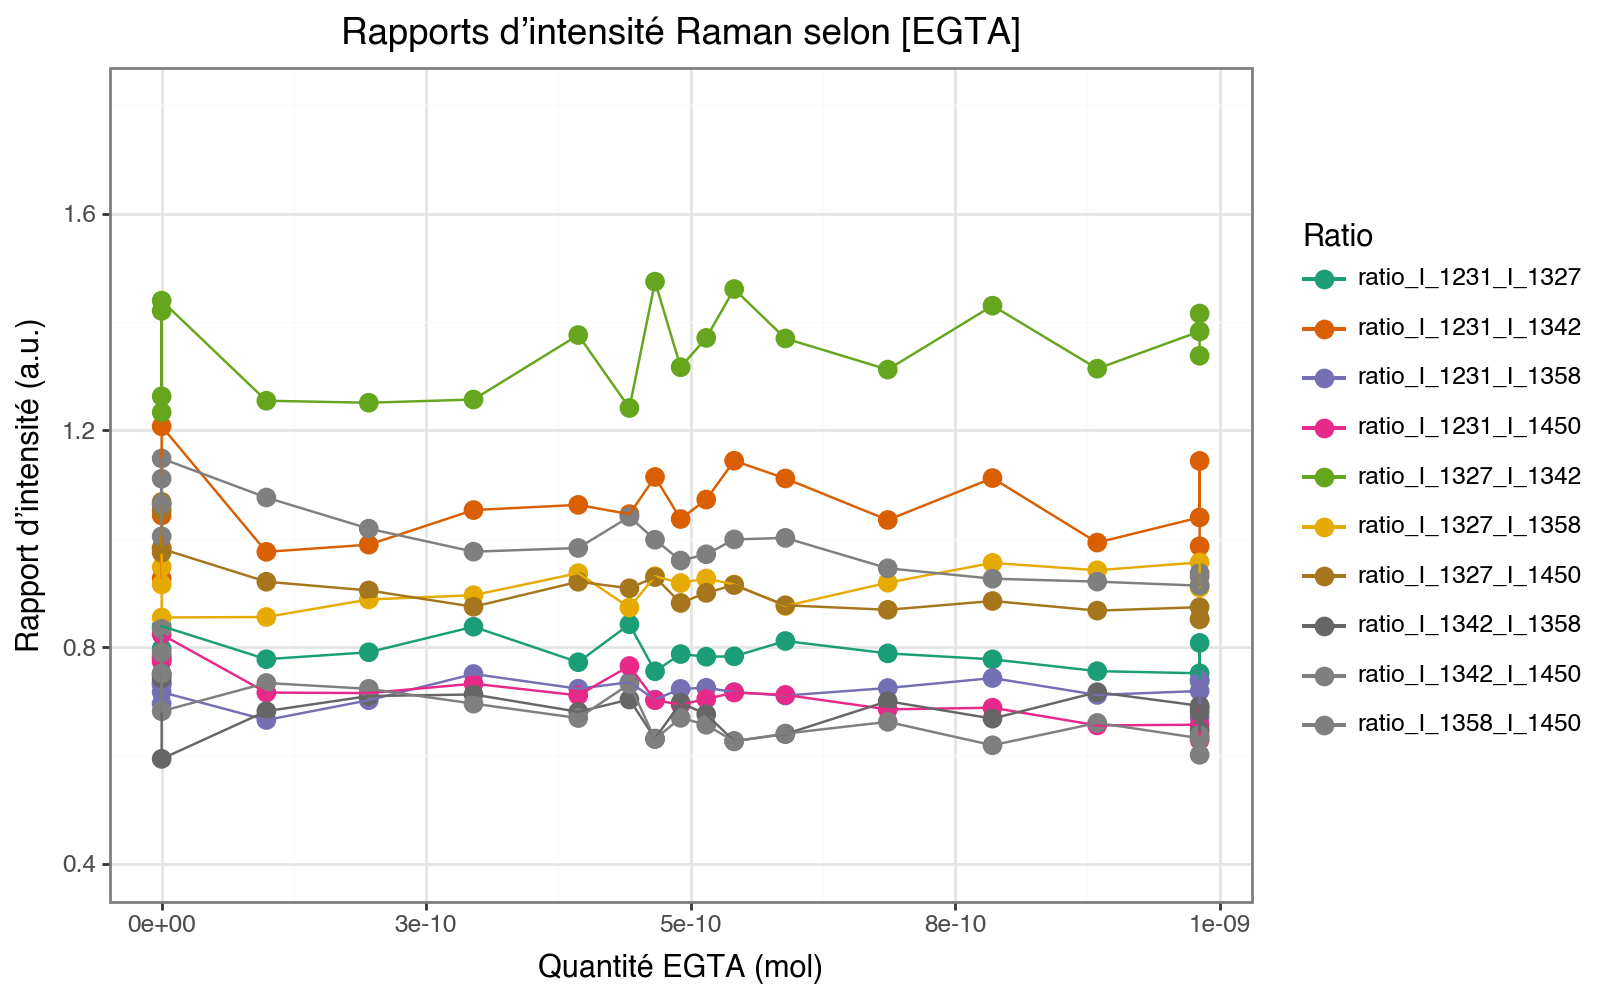

In [216]:
# Tracé
p = (
    ggplot(df_ratios, aes(x="n(EGTA) (mol)", y="Value", color="Ratio"))
    + geom_point(size=3)
    + geom_line(aes(group="Ratio"))
    + theme_bw()
    + labs(
        title="Rapports d’intensité Raman selon [EGTA]",
        x="Quantité EGTA (mol)",
        y="Rapport d’intensité (a.u.)"
    )
    + scale_color_brewer(type='qual', palette='Dark2')
    + scale_x_continuous(labels=lambda l: [f"{x:.0e}" for x in l])
    + theme(figure_size=(8, 5))
    + ylim(0.4, 1.8)
)

p